In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import accelerate
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch.optim as optim
import pickle
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer,  DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from collections import Counter
from datasets import Dataset, DatasetDict, load_dataset

c:\Python_Env\fyp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### **Train FinBert with ClassWeight Balanced Dataset**

In [ ]:
# 1. Load Dataset
finbalance_df = pd.read_csv("Datasets\\news_twitt_integrated_fin.csv")
print(f"Loaded balanced dataset with {len(finbalance_df)} samples.")

# 2. Define raw_label as column sentiment
raw_label = finbalance_df['sentiment'].values

le = LabelEncoder()
train_label = le.fit_transform(raw_label)
num_labels = len(le.classes_) 

print(f"Labels converted to integers (0, 1, 2...): {train_label.dtype}. Num labels: {num_labels}")

# 3. Calculate Class Weights (The Missing Piece)
classes = np.unique(train_label)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_label
)

# 4. Convert to a PyTorch tensor and move to the appropriate device
#    DEFINED weights_tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float) 
print("Class weights (Tensor format):", weights_tensor)


Loaded balanced dataset with 281753 samples.
Labels converted to integers (0, 1, 2...): int64. Num labels: 3
Class weights (Tensor format): tensor([1.0354, 5.7246, 0.5378])


In [ ]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        # The class weights tensor is passed during initialization
        self.weights = kwargs.pop("class_weights", None)
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        # Get the labels
        labels = inputs.pop("labels")
        
        # Get model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Move weights to the same device as the model/inputs (e.g., GPU)
        weights_on_device = self.weights.to(logits.device)
        
        # Define the weighted Cross-Entropy Loss
        loss_fct = nn.CrossEntropyLoss(weight=weights_on_device)
        
        # Calculate the loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        # Return loss and outputs (as expected by Trainer)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Call the model
finbert_model = "ProsusAI/finbert"
fin_tokenizer = AutoTokenizer.from_pretrained(finbert_model)
X = finbalance_df['preprocessed_news'] 

encoded_data = fin_tokenizer(
    X.tolist(),
    padding = True,
    truncation = True,
    return_tensors = 'pt'
)

In [ ]:
# Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    finbert_model, 
    num_labels=num_labels
)
data_dict = {
    'input_ids': encoded_data['input_ids'].tolist(),
    'attention_mask': encoded_data['attention_mask'].tolist(),
    'labels': train_label.tolist() # Ensure your labels are correctly mapped to 0, 1, 2...
}
full_dataset = Dataset.from_dict(data_dict)
# Split the dataset (e.g., 80% train, 20% validation)
train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42) 
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]



In [29]:
# Load the evaluation module
metric = evaluate.load("f1") 

def compute_metrics(eval_pred):
    """
    Computes F1 (Macro/Weighted), Precision, Recall, and Accuracy 
    from model predictions and true labels.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate performance metrics
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    # The classification_report metrics (Precision, Recall, Accuracy)
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "Accuracy": accuracy,
        # 🔑 Crucial for Imbalance: Treat all classes equally
        "F1_macro": f1_macro, 
        # 🔑 Important for overall performance: Weights by class support
        "F1_weighted": f1_weighted, 
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
    }

In [ ]:
# Train Argument
train_args = TrainingArguments(
    output_dir="./finbert_weighted_results", 
    num_train_epochs=3,                   
    per_device_train_batch_size=16,       
    per_device_eval_batch_size=64,        
    warmup_steps=500,                     
    weight_decay=0.01,                    
    logging_dir='./finbert_weighted_logs', 
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True 
)

# --- 6. Start Training ---
trainer = WeightedLossTrainer(
    model=model,                  
    args=train_args,              
    train_dataset=train_dataset,  
    eval_dataset=eval_dataset,
    tokenizer=fin_tokenizer,
    class_weights=weights_tensor, 
    compute_metrics=compute_metrics 
)

C:\Users\JohnTan\AppData\Local\Temp\ipykernel_26348\3936274531.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [33]:
print("Starting standard fine-tuning on balanced data...")
trainer.train()

Starting standard fine-tuning on balanced data...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.349600,0.481403,0.933346,0.867659,0.932744,0.877507,0.858590
2,0.228700,0.510647,0.945698,0.885806,0.944275,0.923079,0.860493
3,0.200600,0.447459,0.954358,0.897141,0.954064,0.902822,0.891830


TrainOutput(global_step=42264, training_loss=0.3597231224227218, metrics={'train_runtime': 19678.8393, 'train_samples_per_second': 34.362, 'train_steps_per_second': 2.148, 'total_flos': 9.632293928828045e+16, 'train_loss': 0.3597231224227218, 'epoch': 3.0})

In [34]:
# Save trained model and tokenizer
save_path = "Models/finbert_trained_model_classweight"

trainer.save_model(save_path)          # Saves model weights, config, and tokenizer
fin_tokenizer.save_pretrained(save_path)   # Saves tokenizer too

print(f"Model saved to: {save_path}")

Model saved to: Models/finbert_trained_model_classweight


##### **Fine-Tune Class Weight FinBERT**

Train size: 225402, Test size: 56351
Label map: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2}

Class Weights: tensor([1.0353, 5.7245, 0.5378])


Map: 100%|██████████| 56351/56351 [00:03<00:00, 16801.26 examples/s]
C:\Users\JohnTan\AppData\Local\Temp\ipykernel_13444\435165947.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.676300,0.427346,0.918138,0.885905,0.838366,0.858312
2,0.370300,0.471668,0.938155,0.924605,0.853864,0.883053
3,0.264900,0.504129,0.943923,0.906252,0.874103,0.888662



Training completed in 140.80 minutes

Model saved to: Models/FinBERT_trained_weighted



=============== FINAL TEST METRICS ===============
              precision    recall  f1-score   support

           0     0.9279    0.9454    0.9366     18142
           1     0.8293    0.7120    0.7662      3281
           2     0.9616    0.9650    0.9633     34928

    accuracy                         0.9439     56351
   macro avg     0.9063    0.8741    0.8887     56351
weighted avg     0.9430    0.9439    0.9432     56351



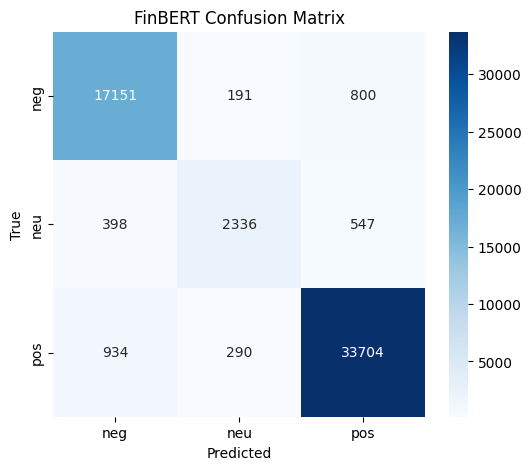

In [ ]:
# 1. Load Dataset

train_df = pd.read_csv("Datasets/train_finbert_raw.csv")
test_df  = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"]  = test_df["preprocessed_news"].fillna("")

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


# ==========================================================
# 2. Label Encoding  (0 = neg, 1 = neu, 2 = pos)

label_map = {label: i for i, label in enumerate(sorted(train_df["label"].unique()))}
print("Label map:", label_map)

train_df["label"] = train_df["label"].map(label_map).astype(int)
test_df["label"]  = test_df["label"].map(label_map).astype(int)

num_labels = len(label_map)


# ==========================================================
# 3. Compute Class Weights from TRAIN ONLY

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"].values),
    y=train_df["label"].values
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("\nClass Weights:", weights_tensor)


# ==========================================================
# 4. Convert to HF Datasets

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)


# ==========================================================
# 5. Tokenizer

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(
        batch["preprocessed_news"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["preprocessed_news"])
test_dataset  = test_dataset.remove_columns(["preprocessed_news"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")


# ==========================================================
# 6. Load FinBERT model

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Slightly stronger dropout → more stable fine-tuning
model.config.hidden_dropout_prob = 0.1
model.config.attention_probs_dropout_prob = 0.1


# ==========================================================
# 7. Custom Weighted Trainer

from torch import nn

class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        # Move weights to GPU if exists
        weights = self.class_weights.to(logits.device)

        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


# ==========================================================
# 8. Metrics

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


# ==========================================================
# 9. Training Arguments

training_args = TrainingArguments(
    output_dir="Models/finbert_weighted_outputs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="f1",

    # More stable than fp16 when using class weights
    bf16=True,
    fp16=False,

    gradient_checkpointing=True,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer)


# ==========================================================
# 10. Trainer

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# ==========================================================
# 11. Train Model

start = time.time()
trainer.train()
print(f"\nTraining completed in {(time.time() - start)/60:.2f} minutes")

# ==========================================================
# 12. Save Model

save_path = "Models/FinBERT_trained_weighted"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nModel saved to: {save_path}")

# ==========================================================
# 13. Final Evaluation

pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)

print("\n=============== FINAL TEST METRICS ===============")
print(classification_report(test_df["label"], preds, digits=4))

cm = confusion_matrix(test_df["label"], preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["neg", "neu", "pos"],
    yticklabels=["neg", "neu", "pos"]
)
plt.title("FinBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


##### **Train FinBert with RandomOverSampling Balanced Dataset**

In [2]:
#Load Train and Test dataset
train_df = pd.read_csv("Datasets/train_finbert_balanced(ros).csv")
test_df = pd.read_csv("Datasets/test_finbert_raw.csv")

# Load FinBERT tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

label_map = {label: i for i, label in enumerate(sorted(train_df['label'].unique()))}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


# Tokenization function
def tokenize_fn(batch):
    return tokenizer(batch['preprocessed_news'], padding='max_length', truncation=True, max_length=254)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

# Set format for PyTorch
train_dataset = train_dataset.remove_columns(['preprocessed_news'])
test_dataset = test_dataset.remove_columns(['preprocessed_news'])


train_dataset.set_format("torch")
test_dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map)
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

Map: 100%|██████████| 56351/56351 [00:05<00:00, 9489.48 examples/s] 


In [3]:
# 6. Training configuration
training_args = TrainingArguments(
    output_dir="./finbert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True,
)

# 7. Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Train the model
trainer.train()
trainer.evaluate()


C:\Users\JohnTan\AppData\Local\Temp\ipykernel_12268\396532338.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.188700,0.391948,0.927827,0.877535,0.866594,0.871921
2,0.050000,0.428363,0.940569,0.914415,0.864026,0.885623


{'eval_loss': 0.39194759726524353,
 'eval_accuracy': 0.9278273677485759,
 'eval_precision': 0.8775354635698515,
 'eval_recall': 0.8665942652100428,
 'eval_f1': 0.871920565980654,
 'eval_runtime': 263.8586,
 'eval_samples_per_second': 213.565,
 'eval_steps_per_second': 26.696,
 'epoch': 2.0}

Test set performance: {'eval_loss': 0.39194759726524353, 'eval_accuracy': 0.9278273677485759, 'eval_precision': 0.8775354635698515, 'eval_recall': 0.8665942652100428, 'eval_f1': 0.871920565980654, 'eval_runtime': 309.9592, 'eval_samples_per_second': 181.801, 'eval_steps_per_second': 22.726, 'epoch': 2.0}
+-------------------------+----------+
| Metric                  |    Value |
+=========================+==========+
| eval_loss               |   0.3919 |
+-------------------------+----------+
| eval_accuracy           |   0.9278 |
+-------------------------+----------+
| eval_precision          |   0.8775 |
+-------------------------+----------+
| eval_recall             |   0.8666 |
+-------------------------+----------+
| eval_f1                 |   0.8719 |
+-------------------------+----------+
| eval_runtime            | 309.959  |
+-------------------------+----------+
| eval_samples_per_second | 181.801  |
+-------------------------+----------+
| eval_steps_per_second   |  22

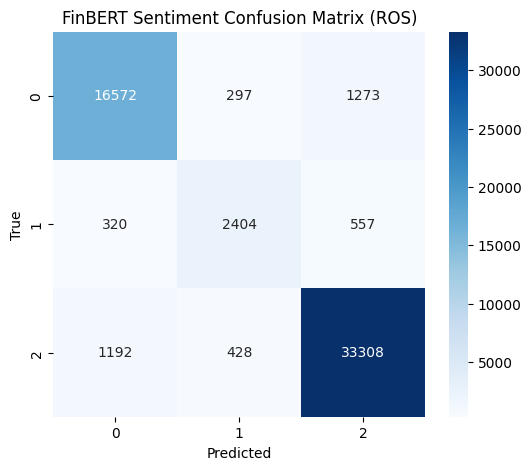

In [4]:
# 9. Evaluate on test set
results = trainer.evaluate()
print("Test set performance:", results)

table_data = [[k, f"{v:.4f}"] for k, v in results.items()]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="grid"))

preds_output = trainer.predict(test_dataset)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(-1)

inv_label_map = {v: k for k, v in label_map.items()}

# Convert integers to label names
y_true_labels = [inv_label_map[i] for i in y_true]
y_pred_labels = [inv_label_map[i] for i in y_pred]

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(inv_label_map.values()))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(inv_label_map.values()),
            yticklabels=list(inv_label_map.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("FinBERT Sentiment Confusion Matrix (ROS)")
plt.show()

In [ ]:
# Save trained model and tokenizer
save_path = "Models/finbert_trained_model_oversampling(ros)"

trainer.save_model(save_path)          
tokenizer.save_pretrained(save_path)   

print(f"Model saved to: {save_path}")

Model saved to: Models/finbert_trained_model_oversampling(ros)


##### **Hyperparameter Tune FinBERT**

Map: 100%|██████████| 56351/56351 [00:03<00:00, 16150.68 examples/s]
C:\Users\JohnTan\AppData\Local\Temp\ipykernel_25972\3212945236.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.418100,0.329335,0.922149,0.858447,0.865929,0.862087
2,0.105700,0.365959,0.935121,0.884230,0.869609,0.876491
3,0.038300,0.446956,0.941580,0.910903,0.869257,0.887712



Training completed in 272.29 minutes

Model saved to: Models/FinBERT_trained_tuned



=============== FINAL TEST METRICS ===============
              precision    recall  f1-score   support

           0     0.9253    0.9408    0.9330     18142
           1     0.8502    0.7025    0.7694      3281
           2     0.9571    0.9644    0.9608     34928

    accuracy                         0.9416     56351
   macro avg     0.9109    0.8693    0.8877     56351
weighted avg     0.9407    0.9416    0.9407     56351



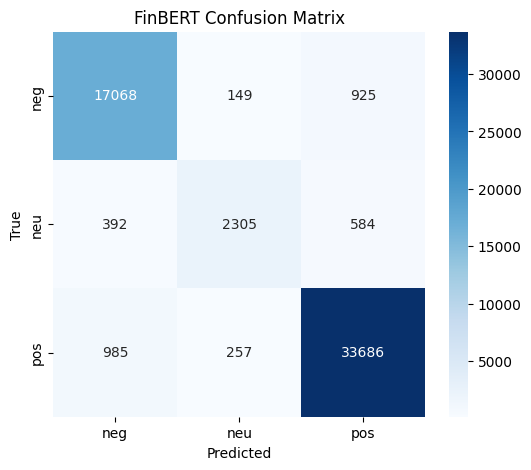

In [ ]:
# 1. Load Train and Test dataset
train_df = pd.read_csv("Datasets/train_finbert_balanced(ros).csv")
test_df = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"] = test_df["preprocessed_news"].fillna("")

# 2. Label encoding (0 = neg, 1 = neu, 2 = pos)
label_map = {label: i for i, label in enumerate(sorted(train_df["label"].unique()))}
train_df["label"] = train_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 3. Tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(
        batch["preprocessed_news"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["preprocessed_news"])
test_dataset = test_dataset.remove_columns(["preprocessed_news"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

# 4. Load FinBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map)
)
# increase for more stable training
model.config.hidden_dropout_prob = 0.1
model.config.attention_probs_dropout_prob = 0.1

# 5. Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# 6. Training Arguments
training_args = TrainingArguments(
    output_dir="Models/finbert_outputs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,                   
    gradient_checkpointing=True,  
    report_to="none"
)
data_collator = DataCollatorWithPadding(tokenizer)


# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# 8. Train
start = time.time()
trainer.train()
print(f"\nTraining completed in {(time.time() - start)/60:.2f} minutes")

# 9. Save Model (YOUR FORMAT)
save_path = "Models/FinBERT_trained_tuned"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nModel saved to: {save_path}")

# 10. Final Evaluation (RAW TEST)
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)

print("\n=============== FINAL TEST METRICS ===============")
print(classification_report(test_df["label"], preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(test_df["label"], preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["neg", "neu", "pos"],
    yticklabels=["neg", "neu", "pos"]
)
plt.title("FinBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()  

##### **Train FinBert with RandomUnderSampling Balanced Dataset**

In [ ]:
#Load Train and Test dataset
trainfu_df = pd.read_csv("Datasets/train_finbert_balanced(rus).csv")
testfu_df = pd.read_csv("Datasets/test_finbert_raw.csv")

# Load FinBERT tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

label_map = {label: i for i, label in enumerate(sorted(trainfu_df['label'].unique()))}
trainfu_df['label'] = trainfu_df['label'].map(label_map)
testfu_df['label'] = testfu_df['label'].map(label_map)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(trainfu_df)
test_dataset = Dataset.from_pandas(testfu_df)

# Tokenization function
def tokenize_fn(batch):
    return tokenizer(batch['preprocessed_news'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

# Set format for PyTorch
train_dataset = train_dataset.remove_columns(['preprocessed_news'])
test_dataset = test_dataset.remove_columns(['preprocessed_news'])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map)
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

Map: 100%|██████████| 56351/56351 [00:03<00:00, 16329.52 examples/s]


In [4]:
# 6. Training configuration
training_args = TrainingArguments(
    output_dir="./finbert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True,
)

# 7. Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Train the model
trainer.train()
trainer.evaluate()

C:\Users\JohnTan\AppData\Local\Temp\ipykernel_18524\3267255501.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.543300,0.562764,0.797111,0.681167,0.800486,0.708384
2,0.337700,0.552936,0.842665,0.729544,0.829782,0.762103


{'eval_loss': 0.5529360175132751,
 'eval_accuracy': 0.8426647264467356,
 'eval_precision': 0.7295439049148591,
 'eval_recall': 0.8297821539686315,
 'eval_f1': 0.7621026163025754,
 'eval_runtime': 339.0248,
 'eval_samples_per_second': 166.215,
 'eval_steps_per_second': 20.777,
 'epoch': 2.0}

Test set performance: {'eval_loss': 0.5529360175132751, 'eval_accuracy': 0.8426647264467356, 'eval_precision': 0.7295439049148591, 'eval_recall': 0.8297821539686315, 'eval_f1': 0.7621026163025754, 'eval_runtime': 261.9457, 'eval_samples_per_second': 215.125, 'eval_steps_per_second': 26.891, 'epoch': 2.0}
+-------------------------+----------+
| Metric                  |    Value |
+=========================+==========+
| eval_loss               |   0.5529 |
+-------------------------+----------+
| eval_accuracy           |   0.8427 |
+-------------------------+----------+
| eval_precision          |   0.7295 |
+-------------------------+----------+
| eval_recall             |   0.8298 |
+-------------------------+----------+
| eval_f1                 |   0.7621 |
+-------------------------+----------+
| eval_runtime            | 261.946  |
+-------------------------+----------+
| eval_samples_per_second | 215.125  |
+-------------------------+----------+
| eval_steps_per_second   |  26

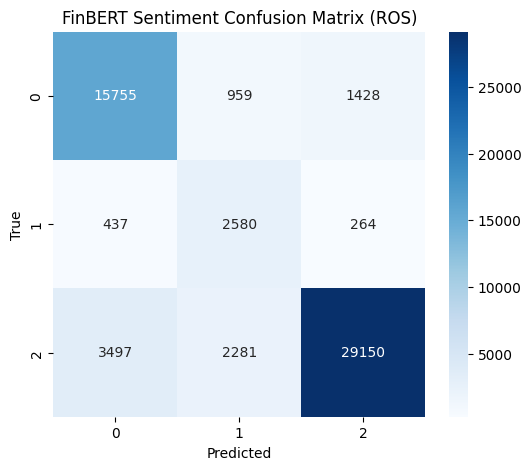

In [5]:
# 9. Evaluate on test set
results = trainer.evaluate()
print("Test set performance:", results)

table_data = [[k, f"{v:.4f}"] for k, v in results.items()]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="grid"))

preds_output = trainer.predict(test_dataset)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(-1)

inv_label_map = {v: k for k, v in label_map.items()}

# Convert integers to label names
y_true_labels = [inv_label_map[i] for i in y_true]
y_pred_labels = [inv_label_map[i] for i in y_pred]

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(inv_label_map.values()))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(inv_label_map.values()),
            yticklabels=list(inv_label_map.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("FinBERT Sentiment Confusion Matrix (ROS)")
plt.show()

In [ ]:
# 10. Save trained model and tokenizer
save_path = "Models/finbert_trained_model_undersampling(rus)"

trainer.save_model(save_path)          
tokenizer.save_pretrained(save_path)   

print(f"Model saved to: {save_path}")

Model saved to: Models/finbert_trained_model_undersampling(rus)


##### **Hyperparameter Tune FinBERT RUS**

Map: 100%|██████████| 56351/56351 [00:03<00:00, 16234.58 examples/s]
C:\Users\JohnTan\AppData\Local\Temp\ipykernel_13444\1862394762.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.879800,0.601089,0.783305,0.667338,0.783166,0.688913
2,0.421600,0.507003,0.840074,0.744385,0.828369,0.775075
3,0.243900,0.572740,0.840642,0.724152,0.830891,0.755742



Training completed in 30.65 minutes

Model saved to: Models/FinBERT_trained_tuned(rus)



=============== FINAL TEST METRICS ===============
              precision    recall  f1-score   support

           0     0.7575    0.8970    0.8214     18142
           1     0.5264    0.7711    0.6257      3281
           2     0.9492    0.8170    0.8781     34928

    accuracy                         0.8401     56351
   macro avg     0.7444    0.8284    0.7751     56351
weighted avg     0.8629    0.8401    0.8452     56351



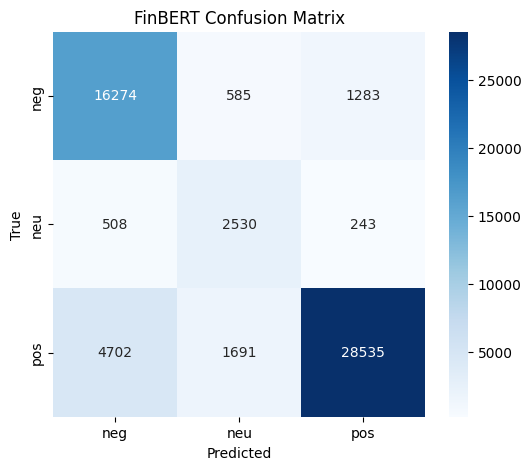

In [ ]:
# 1. Load Train and Test dataset
train_df = pd.read_csv("Datasets/train_finbert_balanced(rus).csv")
test_df = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"] = test_df["preprocessed_news"].fillna("")

# 2. Label encoding (0 = neg, 1 = neu, 2 = pos)
label_map = {label: i for i, label in enumerate(sorted(train_df["label"].unique()))}
train_df["label"] = train_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

# Convert to HF datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 3. Tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(
        batch["preprocessed_news"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["preprocessed_news"])
test_dataset = test_dataset.remove_columns(["preprocessed_news"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

# 4. Load FinBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map)
)
# increase for more stable training
model.config.hidden_dropout_prob = 0.1
model.config.attention_probs_dropout_prob = 0.1

# 5. Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# 6. Training Arguments
training_args = TrainingArguments(
    output_dir="Models/finbert_outputs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,                   
    gradient_checkpointing=True,  
    report_to="none"
)
data_collator = DataCollatorWithPadding(tokenizer)

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# 8. Train
start = time.time()
trainer.train()
print(f"\nTraining completed in {(time.time() - start)/60:.2f} minutes")

# 9. Save Model 
save_path = "Models/FinBERT_trained_tuned(rus)"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nModel saved to: {save_path}")

# 10. Final Evaluation
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)

print("\n=============== FINAL TEST METRICS ===============")
print(classification_report(test_df["label"], preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(test_df["label"], preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["neg", "neu", "pos"],
    yticklabels=["neg", "neu", "pos"]
)
plt.title("FinBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()  

##### **LSTMwith RandomOverSampling Balanced Dataset**

Vocab size = 30002
Using: cuda


100%|██████████| 6549/6549 [01:34<00:00, 69.50it/s]


Epoch 1/10 | Train Loss: 7195.6422 | Val Loss: 980.4085
✔ Model saved (best so far)


100%|██████████| 6549/6549 [01:40<00:00, 65.20it/s]


Epoch 2/10 | Train Loss: 7195.2589 | Val Loss: 972.4636
✔ Model saved (best so far)


100%|██████████| 6549/6549 [01:41<00:00, 64.50it/s]


Epoch 3/10 | Train Loss: 7195.1268 | Val Loss: 965.7071
✔ Model saved (best so far)


100%|██████████| 6549/6549 [01:42<00:00, 63.62it/s]


Epoch 4/10 | Train Loss: 7195.1087 | Val Loss: 969.5484


100%|██████████| 6549/6549 [01:41<00:00, 64.24it/s]


Epoch 5/10 | Train Loss: 7195.0736 | Val Loss: 971.3392


100%|██████████| 6549/6549 [01:41<00:00, 64.58it/s]


Epoch 6/10 | Train Loss: 7195.1649 | Val Loss: 964.8147
✔ Model saved (best so far)


100%|██████████| 6549/6549 [01:40<00:00, 65.17it/s]


Epoch 7/10 | Train Loss: 7195.1601 | Val Loss: 966.8682


100%|██████████| 6549/6549 [01:39<00:00, 66.08it/s]


Epoch 8/10 | Train Loss: 7195.1017 | Val Loss: 974.2027


100%|██████████| 6549/6549 [01:38<00:00, 66.29it/s]


Epoch 9/10 | Train Loss: 7195.1890 | Val Loss: 969.4885
⛔ Early stopping triggered

Training completed in 15.80 minutes

Training Time: 15.80 minutes

================ Evaluation on RAW Test Dataset ================

Accuracy : 0.6198
Precision: 0.2066
Recall   : 0.3333
F1 Score : 0.2551

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     18142
           1     0.0000    0.0000    0.0000      3281
           2     0.6198    1.0000    0.7653     34928

    accuracy                         0.6198     56351
   macro avg     0.2066    0.3333    0.2551     56351
weighted avg     0.3842    0.6198    0.4744     56351



c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


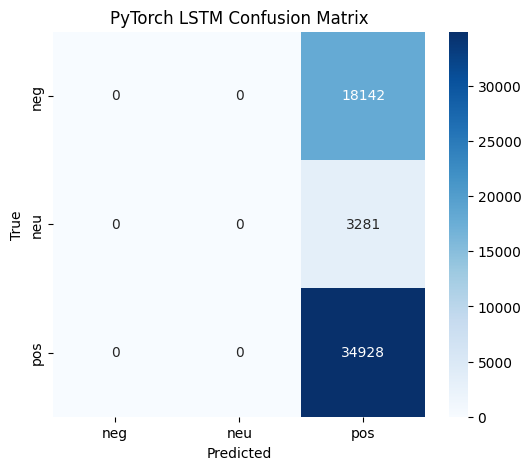

Model and tokenizer saved to: Models/lstm_trained_model_oversampling(ros)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import pickle
from collections import Counter
from torch.nn.utils.rnn import pad_sequence


# 2. Load datasets
train_df = pd.read_csv("Datasets/train_finbert_balanced(ros).csv")
test_df  = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"] = test_df["preprocessed_news"].fillna("")

train_df = shuffle(train_df, random_state=42)

X_train_text = train_df["preprocessed_news"].astype(str).tolist()
y_train = train_df["label"].values

X_test_text = test_df["preprocessed_news"].astype(str).tolist()
y_test = test_df["label"].values



# 3. Tokenization
MAX_WORDS = 30000
MAX_LEN = 256

def build_vocab(texts, max_words=MAX_WORDS):
    counter = Counter()
    for t in texts:
        counter.update(t.lower().split())
    vocab = {w: i+2 for i, (w, _) in enumerate(counter.most_common(max_words))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

vocab = build_vocab(X_train_text)
print("Vocab size =", len(vocab))

def tokenize(text):
    return [vocab.get(w, 1) for w in text.lower().split()]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.tokens = [torch.tensor(tokenize(t), dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

# 4. Define Collate Function
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    padded = padded[:, :MAX_LEN] 

    if padded.size(1) < MAX_LEN:
        pad_amount = MAX_LEN - padded.size(1)
        padded = torch.cat([padded, torch.zeros((padded.size(0), pad_amount), dtype=torch.long)], dim=1)

    return padded.to(device), labels.to(device)

# 5. Create data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

train_ds = TextDataset(X_train_text, y_train)
test_ds  = TextDataset(X_test_text, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

# 6. Build LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, lstm_units=128, num_classes=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(lstm_units*2, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]  
        x = self.dropout1(last_hidden)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

model = LSTMClassifier(len(vocab), 128, 128, 3).to(device)

# 7. Loss, Optimizer + Early Stopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float("inf")
patience = 3
wait = 0


# 8. Train
EPOCHS = 10
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for X, y in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            val_loss += criterion(outputs, y).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "Models/LSTM_best_model.pt")
        print("✔ Model saved (best so far)")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping triggered")
            break

print(f"\nTraining completed in {(time.time()-start)/60:.2f} minutes")
print(f"\nTraining Time: {(time.time()-start)/60:.2f} minutes")


# 9. Evaluation
model.load_state_dict(torch.load("Models/LSTM_best_model.pt"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro", zero_division=0
)

print("\n================ Evaluation on RAW Test Dataset ================\n")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")
print(classification_report(all_labels, all_preds, digits=4))


# 10. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg", "neu", "pos"],
            yticklabels=["neg", "neu", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PyTorch LSTM Confusion Matrix")
plt.show()


# 11. Save tokenizer
save_path = "Models/lstm_trained_model_oversampling(ros)"
# Save PyTorch model
torch.save(model.state_dict(), f"{save_path}/pytorch_model.pt")
# Save tokenizer/vocab
with open(f"{save_path}/tokenizer.pkl", "wb") as f:
    pickle.dump(vocab, f)

print(f"Model and tokenizer saved to: {save_path}")

##### **Hyperparameter Tune LSTM with RandomOverSampling Balanced Dataset**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import pickle
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import optuna      


# 1. Load dataset
train_df = pd.read_csv("Datasets/train_finbert_balanced(ros).csv")
test_df  = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"] = test_df["preprocessed_news"].fillna("")

train_df = shuffle(train_df, random_state=42)

X_train_text = train_df["preprocessed_news"].astype(str).tolist()
y_train = train_df["label"].values

X_test_text = test_df["preprocessed_news"].astype(str).tolist()
y_test = test_df["label"].values


# 2. Tokenization
MAX_WORDS = 30000
MAX_LEN = 256

def build_vocab(texts, max_words=MAX_WORDS):
    counter = Counter()
    for t in texts:
        counter.update(t.lower().split())
    vocab = {w: i+2 for i, (w, _) in enumerate(counter.most_common(max_words))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

vocab = build_vocab(X_train_text)

def tokenize(text):
    return [vocab.get(w, 1) for w in text.lower().split()]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.tokens = [torch.tensor(tokenize(t), dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    padded = padded[:, :MAX_LEN]

    if padded.size(1) < MAX_LEN:
        pad_amount = MAX_LEN - padded.size(1)
        padded = torch.cat([padded, torch.zeros((padded.size(0), pad_amount), dtype=torch.long)], dim=1)

    return padded.to(device), labels.to(device)



# 3. LSTM MODEL
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, dropout1, dropout2, num_classes=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(lstm_units * 2, 64)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        x = self.dropout1(last_hidden)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)



# 4. OPTUNA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def objective(trial):
    # Search Hyperparameter
    embed_dim = trial.suggest_categorical("embed_dim", [64, 128, 256])
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 256])
    dropout1 = trial.suggest_float("dropout1", 0.2, 0.6)
    dropout2 = trial.suggest_float("dropout2", 0.2, 0.6)
    lr = trial.suggest_float("lr", 1e-4, 5e-3)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = LSTMClassifier(len(vocab), embed_dim, lstm_units, dropout1, dropout2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_ds = TextDataset(X_train_text, y_train)
    test_ds = TextDataset(X_test_text, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    best_val_loss = float("inf")
    patience = 2
    wait = 0

    for epoch in range(5): 
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                val_loss += criterion(model(X), y).item()

        # Early stop inside trial
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
    return best_val_loss

# 5. RUN OPTUNA
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)   

print("\nBest Hyperparameters:", study.best_params)


# 6. Train final model with best params
best = study.best_params
model = LSTMClassifier(
    len(vocab),
    best["embed_dim"],
    best["lstm_units"],
    best["dropout1"],
    best["dropout2"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss()

train_ds = TextDataset(X_train_text, y_train)
test_ds  = TextDataset(X_test_text, y_test)

train_loader = DataLoader(train_ds, batch_size=best["batch_size"], shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=best["batch_size"], shuffle=False, collate_fn=collate_fn)

best_val_loss = float("inf")
patience = 3
wait = 0

for epoch in range(10):
    model.train()
    total_loss = 0
    for X, y in tqdm(train_loader):
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            val_loss += criterion(model(X), y).item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "Models/LSTM_best_model.pt")
        print("✔ Saved best model")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping")
            break


# 7. Evaluation
model.load_state_dict(torch.load("Models/LSTM_best_model.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print("\nFinal Report:")
print(classification_report(all_labels, all_preds, digits=4))


# 8. Save vocab/tokenizer
save_path = "Models/lstm_trained_model_optuna"

import os
os.makedirs(save_path, exist_ok=True)
# Save model
torch.save(model.state_dict(), f"{save_path}/pytorch_model.pt")
# Save tokenizer/vocab
with open(f"{save_path}/tokenizer.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("Model saved to:", save_path)


[I 2025-12-10 01:38:34,681] A new study created in memory with name: no-name-cb470708-2bde-4110-94fc-84f9882e3f17
[I 2025-12-10 01:42:32,383] Trial 0 finished with value: 958.6910591125488 and parameters: {'embed_dim': 256, 'lstm_units': 64, 'dropout1': 0.21441392209258706, 'dropout2': 0.28148746738912234, 'lr': 0.003477152840980698, 'batch_size': 64}. Best is trial 0 with value: 958.6910591125488.
[I 2025-12-10 02:23:44,815] Trial 1 finished with value: 1912.8357614278793 and parameters: {'embed_dim': 256, 'lstm_units': 256, 'dropout1': 0.4783119738743503, 'dropout2': 0.47599409367505113, 'lr': 0.0049315046187638515, 'batch_size': 32}. Best is trial 0 with value: 958.6910591125488.
[I 2025-12-10 02:46:23,760] Trial 2 finished with value: 964.6785103082657 and parameters: {'embed_dim': 256, 'lstm_units': 256, 'dropout1': 0.2348339902477024, 'dropout2': 0.25285936839254386, 'lr': 0.0014438190635253758, 'batch_size': 64}. Best is trial 0 with value: 958.6910591125488.
[I 2025-12-10 03:00


Best Hyperparameters: {'embed_dim': 128, 'lstm_units': 128, 'dropout1': 0.2043321557943922, 'dropout2': 0.4277803703900158, 'lr': 0.004904023847294014, 'batch_size': 128}


100%|██████████| 3275/3275 [01:22<00:00, 39.79it/s]


Epoch 1 | Train Loss: 3598.5668 | Val Loss: 488.1764
✔ Saved best model


100%|██████████| 3275/3275 [01:23<00:00, 39.45it/s]


Epoch 2 | Train Loss: 3598.4257 | Val Loss: 479.8815
✔ Saved best model


100%|██████████| 3275/3275 [01:24<00:00, 38.83it/s]


Epoch 3 | Train Loss: 3599.0504 | Val Loss: 484.9387


100%|██████████| 3275/3275 [01:24<00:00, 38.98it/s]


Epoch 4 | Train Loss: 3598.6002 | Val Loss: 488.0832


100%|██████████| 3275/3275 [01:24<00:00, 38.91it/s]


Epoch 5 | Train Loss: 3598.5268 | Val Loss: 481.4040
⛔ Early stopping

Final Report:
              precision    recall  f1-score   support

           0     0.3219    1.0000    0.4871     18142
           1     0.0000    0.0000    0.0000      3281
           2     0.0000    0.0000    0.0000     34928

    accuracy                         0.3219     56351
   macro avg     0.1073    0.3333    0.1624     56351
weighted avg     0.1036    0.3219    0.1568     56351

Model saved to: Models/lstm_trained_model_optuna


c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### **LSTM with RandomUnderSampling Balanced Dataset**

Vocab size = 30002
Using: cuda


100%|██████████| 616/616 [00:07<00:00, 79.12it/s]


Epoch 1/10 | Train Loss: 677.1077 | Val Loss: 974.9130
✔ Model saved (best so far)


100%|██████████| 616/616 [00:07<00:00, 81.00it/s]


Epoch 2/10 | Train Loss: 676.8649 | Val Loss: 978.3020


100%|██████████| 616/616 [00:07<00:00, 78.70it/s]


Epoch 3/10 | Train Loss: 676.7895 | Val Loss: 966.4503
✔ Model saved (best so far)


100%|██████████| 616/616 [00:08<00:00, 74.44it/s]


Epoch 4/10 | Train Loss: 676.8991 | Val Loss: 970.5121


100%|██████████| 616/616 [00:08<00:00, 71.06it/s]


Epoch 5/10 | Train Loss: 676.8604 | Val Loss: 970.1940


100%|██████████| 616/616 [00:08<00:00, 68.91it/s]


Epoch 6/10 | Train Loss: 676.7614 | Val Loss: 966.3915
✔ Model saved (best so far)


100%|██████████| 616/616 [00:09<00:00, 66.53it/s]


Epoch 7/10 | Train Loss: 676.7947 | Val Loss: 966.2415
✔ Model saved (best so far)


100%|██████████| 616/616 [00:09<00:00, 65.76it/s]


Epoch 8/10 | Train Loss: 676.7898 | Val Loss: 962.4062
✔ Model saved (best so far)


100%|██████████| 616/616 [00:09<00:00, 65.14it/s]


Epoch 9/10 | Train Loss: 676.8047 | Val Loss: 960.9608
✔ Model saved (best so far)


100%|██████████| 616/616 [00:09<00:00, 64.74it/s]


Epoch 10/10 | Train Loss: 676.8060 | Val Loss: 968.2250

Training completed in 2.26 minutes

Training Time: 2.26 minutes

================ Evaluation on RAW Test Dataset ================

Accuracy : 0.6198
Precision: 0.2066
Recall   : 0.3333
F1 Score : 0.2551

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     18142
           1     0.0000    0.0000    0.0000      3281
           2     0.6198    1.0000    0.7653     34928

    accuracy                         0.6198     56351
   macro avg     0.2066    0.3333    0.2551     56351
weighted avg     0.3842    0.6198    0.4744     56351



c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


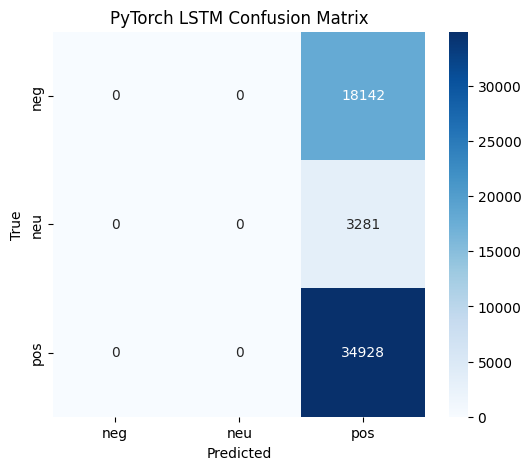

Model and tokenizer saved to: Models/lstm_trained_model_undersampling(rus)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import pickle
from collections import Counter
from torch.nn.utils.rnn import pad_sequence


# 2. Load oversampled train + raw test datasets
train_df = pd.read_csv("Datasets/train_finbert_balanced(rus).csv")
test_df  = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"] = test_df["preprocessed_news"].fillna("")

train_df = shuffle(train_df, random_state=42)

X_train_text = train_df["preprocessed_news"].astype(str).tolist()
y_train = train_df["label"].values

X_test_text = test_df["preprocessed_news"].astype(str).tolist()
y_test = test_df["label"].values



# 3. Tokenization
MAX_WORDS = 30000
MAX_LEN = 256
def build_vocab(texts, max_words=MAX_WORDS):
    counter = Counter()
    for t in texts:
        counter.update(t.lower().split())
    vocab = {w: i+2 for i, (w, _) in enumerate(counter.most_common(max_words))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab
vocab = build_vocab(X_train_text)
print("Vocab size =", len(vocab))

def tokenize(text):
    return [vocab.get(w, 1) for w in text.lower().split()]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.tokens = [torch.tensor(tokenize(t), dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

# 4. Define Collate Function
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    padded = padded[:, :MAX_LEN]  # trim or pad to MAX_LEN

    if padded.size(1) < MAX_LEN:
        pad_amount = MAX_LEN - padded.size(1)
        padded = torch.cat([padded, torch.zeros((padded.size(0), pad_amount), dtype=torch.long)], dim=1)
    return padded.to(device), labels.to(device)



# 5. Create data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

train_ds = TextDataset(X_train_text, y_train)
test_ds  = TextDataset(X_test_text, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)


# 6. Build LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, lstm_units=128, num_classes=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(lstm_units*2, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :] 
        x = self.dropout1(last_hidden)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

model = LSTMClassifier(len(vocab), 128, 128, 3).to(device)

# 7. Loss, Optimizer, Early Stopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float("inf")
patience = 3
wait = 0



# 8. Train
EPOCHS = 10
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for X, y in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            val_loss += criterion(outputs, y).item()
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "Models/LSTM_best_model.pt")
        print("✔ Model saved (best so far)")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping triggered")
            break
print(f"\nTraining completed in {(time.time()-start)/60:.2f} minutes")
print(f"\nTraining Time: {(time.time()-start)/60:.2f} minutes")


# 9. Evaluation
model.load_state_dict(torch.load("Models/LSTM_best_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro", zero_division=0
)

print("\n================ Evaluation on RAW Test Dataset ================\n")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")

print(classification_report(all_labels, all_preds, digits=4))

# 10. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg", "neu", "pos"],
            yticklabels=["neg", "neu", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PyTorch LSTM Confusion Matrix")
plt.show()

# 11. Save tokenizer
save_path = "Models/lstm_trained_model_undersampling(rus)"
# Save PyTorch model
torch.save(model.state_dict(), f"{save_path}/pytorch_model.pt")
# Save tokenizer/vocab
with open(f"{save_path}/tokenizer.pkl", "wb") as f:
    pickle.dump(vocab, f)

print(f"Model and tokenizer saved to: {save_path}")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import pickle
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import optuna      # ← ← ← OPTUNA HERE

# 1. Load dataset
train_df = pd.read_csv("Datasets/train_finbert_balanced(rus).csv")
test_df  = pd.read_csv("Datasets/test_finbert_raw.csv")

train_df["preprocessed_news"] = train_df["preprocessed_news"].fillna("")
test_df["preprocessed_news"] = test_df["preprocessed_news"].fillna("")

train_df = shuffle(train_df, random_state=42)

X_train_text = train_df["preprocessed_news"].astype(str).tolist()
y_train = train_df["label"].values

X_test_text = test_df["preprocessed_news"].astype(str).tolist()
y_test = test_df["label"].values



# 2. Tokenization
MAX_WORDS = 30000
MAX_LEN = 256

def build_vocab(texts, max_words=MAX_WORDS):
    counter = Counter()
    for t in texts:
        counter.update(t.lower().split())
    vocab = {w: i+2 for i, (w, _) in enumerate(counter.most_common(max_words))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

vocab = build_vocab(X_train_text)
def tokenize(text):
    return [vocab.get(w, 1) for w in text.lower().split()]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.tokens = [torch.tensor(tokenize(t), dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    padded = padded[:, :MAX_LEN]

    if padded.size(1) < MAX_LEN:
        pad_amount = MAX_LEN - padded.size(1)
        padded = torch.cat([padded, torch.zeros((padded.size(0), pad_amount), dtype=torch.long)], dim=1)
    return padded.to(device), labels.to(device)



# 3. LSTM MODEL
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, dropout1, dropout2, num_classes=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(lstm_units * 2, 64)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        x = self.dropout1(last_hidden)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)



# 4. OPTUNA OBJECTIVE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def objective(trial):
    # Hyperparameters to search
    embed_dim = trial.suggest_categorical("embed_dim", [64, 128, 256])
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 256])
    dropout1 = trial.suggest_float("dropout1", 0.2, 0.6)
    dropout2 = trial.suggest_float("dropout2", 0.2, 0.6)
    lr = trial.suggest_float("lr", 1e-4, 5e-3)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = LSTMClassifier(len(vocab), embed_dim, lstm_units, dropout1, dropout2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_ds = TextDataset(X_train_text, y_train)
    test_ds = TextDataset(X_test_text, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    best_val_loss = float("inf")
    patience = 2
    wait = 0

    for epoch in range(5):  
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                val_loss += criterion(model(X), y).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return best_val_loss

# 5. RUN OPTUNA
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) 

print("\nBest Hyperparameters:", study.best_params)



# 6. Train final model with best params
best = study.best_params
model = LSTMClassifier(
    len(vocab),
    best["embed_dim"],
    best["lstm_units"],
    best["dropout1"],
    best["dropout2"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best["lr"])
criterion = nn.CrossEntropyLoss()

train_ds = TextDataset(X_train_text, y_train)
test_ds  = TextDataset(X_test_text, y_test)

train_loader = DataLoader(train_ds, batch_size=best["batch_size"], shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=best["batch_size"], shuffle=False, collate_fn=collate_fn)

best_val_loss = float("inf")
patience = 3
wait = 0

for epoch in range(10):
    model.train()
    total_loss = 0

    for X, y in tqdm(train_loader):
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            val_loss += criterion(model(X), y).item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "Models/LSTM_best_model.pt")
        print("✔ Saved best model")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping")
            break



# 7. Evaluation
model.load_state_dict(torch.load("Models/LSTM_best_model.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print("\nFinal Report:")
print(classification_report(all_labels, all_preds, digits=4))



# 8. Save vocab/tokenizer
save_path = "Models/lstm_trained_model_optuna_rus"

import os
os.makedirs(save_path, exist_ok=True)
# Save model
torch.save(model.state_dict(), f"{save_path}/pytorch_model.pt")
# Save tokenizer/vocab
with open(f"{save_path}/tokenizer.pkl", "wb") as f:
    pickle.dump(vocab, f)
print("Model saved to:", save_path)


[I 2025-12-10 08:02:10,181] A new study created in memory with name: no-name-797a0c7f-6d3b-44b0-97fa-e26e88d9d179
[I 2025-12-10 08:04:07,901] Trial 0 finished with value: 484.0111562013626 and parameters: {'embed_dim': 256, 'lstm_units': 256, 'dropout1': 0.23686572979956685, 'dropout2': 0.27402406908995836, 'lr': 0.004907561356765446, 'batch_size': 128}. Best is trial 0 with value: 484.0111562013626.
[I 2025-12-10 08:07:23,734] Trial 1 finished with value: 1900.1107647418976 and parameters: {'embed_dim': 128, 'lstm_units': 256, 'dropout1': 0.3572951257125833, 'dropout2': 0.26114834101737744, 'lr': 0.0029020228100066106, 'batch_size': 32}. Best is trial 0 with value: 484.0111562013626.
[I 2025-12-10 08:07:40,211] Trial 2 finished with value: 482.37340450286865 and parameters: {'embed_dim': 64, 'lstm_units': 64, 'dropout1': 0.2512290397867734, 'dropout2': 0.5123326713810308, 'lr': 0.0003991185228384585, 'batch_size': 128}. Best is trial 2 with value: 482.37340450286865.
[I 2025-12-10 08:


Best Hyperparameters: {'embed_dim': 128, 'lstm_units': 64, 'dropout1': 0.5605059570534606, 'dropout2': 0.40911940718160245, 'lr': 0.004141188091807378, 'batch_size': 128}


100%|██████████| 308/308 [00:02<00:00, 103.00it/s]


Epoch 1 | Train Loss: 338.6633 | Val Loss: 490.3341
✔ Saved best model


100%|██████████| 308/308 [00:03<00:00, 102.38it/s]


Epoch 2 | Train Loss: 338.4661 | Val Loss: 482.0230
✔ Saved best model


100%|██████████| 308/308 [00:02<00:00, 102.67it/s]


Epoch 3 | Train Loss: 338.4361 | Val Loss: 486.0627


100%|██████████| 308/308 [00:02<00:00, 103.20it/s]


Epoch 4 | Train Loss: 338.4300 | Val Loss: 484.1218


100%|██████████| 308/308 [00:03<00:00, 100.51it/s]


Epoch 5 | Train Loss: 338.4164 | Val Loss: 483.9082
⛔ Early stopping

Final Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     18142
           1     0.0000    0.0000    0.0000      3281
           2     0.6198    1.0000    0.7653     34928

    accuracy                         0.6198     56351
   macro avg     0.2066    0.3333    0.2551     56351
weighted avg     0.3842    0.6198    0.4744     56351

Model saved to: Models/lstm_trained_model_optuna_rus


c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python_Env\fyp_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
